# Лабораторная работа #2

## Сбор данных для обучения

Датасет был собран путём парсинга сайта https://www.anekdot.ru/. Взял все анекдоты за 2021 год и 2020 года, всего около 54,000 штук.
Для парсинга использовал библиотку `BeautifulSoup4`

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from itertools import product

years = ['2020', '2021']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
days = ['01', '02', '03', '04', '05', '06', '07', '08', '09'] + [str(x) for x in range(10, 29)]
base_url = 'https://www.anekdot.ru/release/anekdot/day/'

jokes = []
for (year, month, day) in product(years, months, days):
    if day == '01':
        print(f'{year}.{month}...')

    url = base_url + year + '-' + month + '-' + day + '/'
    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    search_result = soup.find_all('div', class_='topicbox')

    for box in search_result:
        text = box.findAll('div', class_='text')
        if len(text):
            jokes.append(text[0].get_text().replace('\r', ' ').replace('\xad', ' '))

print(f'Number of jokes: {len(jokes)}')

df = pd.DataFrame({'Jokes': jokes})

## Данные

Читаем данные из файла

In [1]:
import pandas as pd

jokes_df = pd.read_csv('jokes.csv')
jokes_df.shape

(54244, 1)

In [12]:
jokes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54244 entries, 0 to 54243
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Jokes   54244 non-null  object
dtypes: object(1)
memory usage: 423.9+ KB


Распределение длин анекдотов

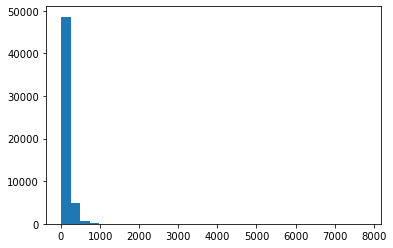

In [18]:
from matplotlib import pyplot as plt

plt.hist([len(joke) for joke in jokes_df.Jokes.values], bins=32)
plt.show()

Разделим датасет на тренировочную и валидационную выборки

In [2]:
n_train = int(0.8 * jokes_df.shape[0])
x_train = jokes_df.Jokes.values[:n_train].tolist()
x_val = jokes_df.Jokes.values[n_train:].tolist()

In [3]:
len(x_train), len(x_val)

(43395, 10849)

## Построение модели

За основу возьмём модель от Сбера и дообучим её на анекдотах

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
from datasets import Dataset

tokenizer.pad_token = tokenizer.eos_token

tokenized_train = tokenizer(x_train, truncation=True, padding='max_length', max_length=42)
tokenized_val = tokenizer(x_val, truncation=True, padding='max_length', max_length=42)

tokenized_train['labels'] = tokenized_train['input_ids'].copy()
tokenized_val['labels'] = tokenized_val['input_ids'].copy()

tokenized_train = Dataset.from_dict(tokenized_train)
tokenized_val = Dataset.from_dict(tokenized_val)

In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments('test_trainer')
trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_train, eval_dataset=tokenized_val)

In [7]:
trainer.train()

***** Running training *****
  Num examples = 43395
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16275
  3%|▎         | 500/16275 [24:04<12:33:20,  2.87s/it]Saving model checkpoint to test_trainer\checkpoint-500
Configuration saved in test_trainer\checkpoint-500\config.json


{'loss': 2.9801, 'learning_rate': 4.846390168970814e-05, 'epoch': 0.09}


Model weights saved in test_trainer\checkpoint-500\pytorch_model.bin
  6%|▌         | 1000/16275 [48:15<12:22:03,  2.91s/it]Saving model checkpoint to test_trainer\checkpoint-1000
Configuration saved in test_trainer\checkpoint-1000\config.json


{'loss': 2.8076, 'learning_rate': 4.692780337941628e-05, 'epoch': 0.18}


Model weights saved in test_trainer\checkpoint-1000\pytorch_model.bin
  9%|▉         | 1500/16275 [1:12:58<11:36:44,  2.83s/it]Saving model checkpoint to test_trainer\checkpoint-1500
Configuration saved in test_trainer\checkpoint-1500\config.json


{'loss': 2.7654, 'learning_rate': 4.539170506912442e-05, 'epoch': 0.28}


Model weights saved in test_trainer\checkpoint-1500\pytorch_model.bin
 12%|█▏        | 2000/16275 [1:42:45<11:17:19,  2.85s/it]Saving model checkpoint to test_trainer\checkpoint-2000
Configuration saved in test_trainer\checkpoint-2000\config.json


{'loss': 2.7695, 'learning_rate': 4.385560675883257e-05, 'epoch': 0.37}


Model weights saved in test_trainer\checkpoint-2000\pytorch_model.bin
 15%|█▌        | 2500/16275 [2:07:11<11:13:48,  2.93s/it]Saving model checkpoint to test_trainer\checkpoint-2500
Configuration saved in test_trainer\checkpoint-2500\config.json


{'loss': 2.7252, 'learning_rate': 4.231950844854071e-05, 'epoch': 0.46}


Model weights saved in test_trainer\checkpoint-2500\pytorch_model.bin
 18%|█▊        | 3000/16275 [2:31:30<10:30:12,  2.85s/it]Saving model checkpoint to test_trainer\checkpoint-3000
Configuration saved in test_trainer\checkpoint-3000\config.json


{'loss': 2.7362, 'learning_rate': 4.078341013824885e-05, 'epoch': 0.55}


Model weights saved in test_trainer\checkpoint-3000\pytorch_model.bin
 22%|██▏       | 3500/16275 [2:59:59<13:39:43,  3.85s/it]Saving model checkpoint to test_trainer\checkpoint-3500
Configuration saved in test_trainer\checkpoint-3500\config.json


{'loss': 2.738, 'learning_rate': 3.924731182795699e-05, 'epoch': 0.65}


Model weights saved in test_trainer\checkpoint-3500\pytorch_model.bin
 25%|██▍       | 4000/16275 [3:33:11<13:32:20,  3.97s/it]Saving model checkpoint to test_trainer\checkpoint-4000
Configuration saved in test_trainer\checkpoint-4000\config.json


{'loss': 2.7172, 'learning_rate': 3.7711213517665136e-05, 'epoch': 0.74}


Model weights saved in test_trainer\checkpoint-4000\pytorch_model.bin
 28%|██▊       | 4500/16275 [4:06:17<12:45:25,  3.90s/it]Saving model checkpoint to test_trainer\checkpoint-4500
Configuration saved in test_trainer\checkpoint-4500\config.json


{'loss': 2.7143, 'learning_rate': 3.6175115207373276e-05, 'epoch': 0.83}


Model weights saved in test_trainer\checkpoint-4500\pytorch_model.bin
 31%|███       | 5000/16275 [4:39:29<12:40:11,  4.05s/it]Saving model checkpoint to test_trainer\checkpoint-5000
Configuration saved in test_trainer\checkpoint-5000\config.json


{'loss': 2.6718, 'learning_rate': 3.4639016897081416e-05, 'epoch': 0.92}


Model weights saved in test_trainer\checkpoint-5000\pytorch_model.bin
 34%|███▍      | 5500/16275 [5:12:33<11:34:19,  3.87s/it]Saving model checkpoint to test_trainer\checkpoint-5500
Configuration saved in test_trainer\checkpoint-5500\config.json


{'loss': 2.6504, 'learning_rate': 3.3102918586789556e-05, 'epoch': 1.01}


Model weights saved in test_trainer\checkpoint-5500\pytorch_model.bin
 37%|███▋      | 6000/16275 [5:36:15<9:16:01,  3.25s/it] Saving model checkpoint to test_trainer\checkpoint-6000
Configuration saved in test_trainer\checkpoint-6000\config.json


{'loss': 2.3254, 'learning_rate': 3.15668202764977e-05, 'epoch': 1.11}


Model weights saved in test_trainer\checkpoint-6000\pytorch_model.bin
 40%|███▉      | 6500/16275 [6:07:23<10:46:24,  3.97s/it]Saving model checkpoint to test_trainer\checkpoint-6500
Configuration saved in test_trainer\checkpoint-6500\config.json


{'loss': 2.3353, 'learning_rate': 3.003072196620584e-05, 'epoch': 1.2}


Model weights saved in test_trainer\checkpoint-6500\pytorch_model.bin
 43%|████▎     | 7000/16275 [6:39:52<10:02:56,  3.90s/it]Saving model checkpoint to test_trainer\checkpoint-7000
Configuration saved in test_trainer\checkpoint-7000\config.json


{'loss': 2.3329, 'learning_rate': 2.8494623655913982e-05, 'epoch': 1.29}


Model weights saved in test_trainer\checkpoint-7000\pytorch_model.bin
 46%|████▌     | 7500/16275 [7:13:09<9:38:45,  3.96s/it] Saving model checkpoint to test_trainer\checkpoint-7500
Configuration saved in test_trainer\checkpoint-7500\config.json


{'loss': 2.3397, 'learning_rate': 2.6958525345622122e-05, 'epoch': 1.38}


Model weights saved in test_trainer\checkpoint-7500\pytorch_model.bin
 49%|████▉     | 8000/16275 [7:46:29<9:18:33,  4.05s/it] Saving model checkpoint to test_trainer\checkpoint-8000
Configuration saved in test_trainer\checkpoint-8000\config.json


{'loss': 2.3369, 'learning_rate': 2.542242703533026e-05, 'epoch': 1.47}


Model weights saved in test_trainer\checkpoint-8000\pytorch_model.bin
 52%|█████▏    | 8500/16275 [8:19:41<8:40:08,  4.01s/it] Saving model checkpoint to test_trainer\checkpoint-8500
Configuration saved in test_trainer\checkpoint-8500\config.json


{'loss': 2.3365, 'learning_rate': 2.3886328725038402e-05, 'epoch': 1.57}


Model weights saved in test_trainer\checkpoint-8500\pytorch_model.bin
 55%|█████▌    | 9000/16275 [8:52:56<7:58:23,  3.95s/it] Saving model checkpoint to test_trainer\checkpoint-9000
Configuration saved in test_trainer\checkpoint-9000\config.json


{'loss': 2.3462, 'learning_rate': 2.2350230414746546e-05, 'epoch': 1.66}


Model weights saved in test_trainer\checkpoint-9000\pytorch_model.bin
 58%|█████▊    | 9500/16275 [9:26:16<7:25:32,  3.95s/it] Saving model checkpoint to test_trainer\checkpoint-9500
Configuration saved in test_trainer\checkpoint-9500\config.json


{'loss': 2.3677, 'learning_rate': 2.0814132104454685e-05, 'epoch': 1.75}


Model weights saved in test_trainer\checkpoint-9500\pytorch_model.bin
 61%|██████▏   | 10000/16275 [9:59:28<7:02:23,  4.04s/it]Saving model checkpoint to test_trainer\checkpoint-10000
Configuration saved in test_trainer\checkpoint-10000\config.json


{'loss': 2.3453, 'learning_rate': 1.927803379416283e-05, 'epoch': 1.84}


Model weights saved in test_trainer\checkpoint-10000\pytorch_model.bin
 65%|██████▍   | 10500/16275 [10:32:47<6:21:33,  3.96s/it]Saving model checkpoint to test_trainer\checkpoint-10500
Configuration saved in test_trainer\checkpoint-10500\config.json


{'loss': 2.352, 'learning_rate': 1.774193548387097e-05, 'epoch': 1.94}


Model weights saved in test_trainer\checkpoint-10500\pytorch_model.bin
 68%|██████▊   | 11000/16275 [11:12:40<5:56:36,  4.06s/it]Saving model checkpoint to test_trainer\checkpoint-11000
Configuration saved in test_trainer\checkpoint-11000\config.json


{'loss': 2.2726, 'learning_rate': 1.6205837173579112e-05, 'epoch': 2.03}


Model weights saved in test_trainer\checkpoint-11000\pytorch_model.bin
 71%|███████   | 11500/16275 [17:55:24<5:11:55,  3.92s/it]     Saving model checkpoint to test_trainer\checkpoint-11500
Configuration saved in test_trainer\checkpoint-11500\config.json


{'loss': 2.0613, 'learning_rate': 1.4669738863287252e-05, 'epoch': 2.12}


Model weights saved in test_trainer\checkpoint-11500\pytorch_model.bin
 74%|███████▎  | 12000/16275 [18:28:22<4:35:43,  3.87s/it]Saving model checkpoint to test_trainer\checkpoint-12000
Configuration saved in test_trainer\checkpoint-12000\config.json


{'loss': 2.0834, 'learning_rate': 1.313364055299539e-05, 'epoch': 2.21}


Model weights saved in test_trainer\checkpoint-12000\pytorch_model.bin
 77%|███████▋  | 12500/16275 [19:01:12<4:08:10,  3.94s/it]Saving model checkpoint to test_trainer\checkpoint-12500
Configuration saved in test_trainer\checkpoint-12500\config.json


{'loss': 2.0731, 'learning_rate': 1.1597542242703534e-05, 'epoch': 2.3}


Model weights saved in test_trainer\checkpoint-12500\pytorch_model.bin
 80%|███████▉  | 13000/16275 [19:34:12<3:29:12,  3.83s/it]Saving model checkpoint to test_trainer\checkpoint-13000
Configuration saved in test_trainer\checkpoint-13000\config.json


{'loss': 2.0955, 'learning_rate': 1.0061443932411675e-05, 'epoch': 2.4}


Model weights saved in test_trainer\checkpoint-13000\pytorch_model.bin
 83%|████████▎ | 13500/16275 [20:07:18<3:04:36,  3.99s/it]Saving model checkpoint to test_trainer\checkpoint-13500
Configuration saved in test_trainer\checkpoint-13500\config.json


{'loss': 2.1127, 'learning_rate': 8.525345622119817e-06, 'epoch': 2.49}


Model weights saved in test_trainer\checkpoint-13500\pytorch_model.bin
 86%|████████▌ | 14000/16275 [20:38:18<1:39:26,  2.62s/it]Saving model checkpoint to test_trainer\checkpoint-14000
Configuration saved in test_trainer\checkpoint-14000\config.json


{'loss': 2.0953, 'learning_rate': 6.989247311827957e-06, 'epoch': 2.58}


Model weights saved in test_trainer\checkpoint-14000\pytorch_model.bin
 89%|████████▉ | 14500/16275 [21:01:57<1:17:43,  2.63s/it]Saving model checkpoint to test_trainer\checkpoint-14500
Configuration saved in test_trainer\checkpoint-14500\config.json


{'loss': 2.0894, 'learning_rate': 5.453149001536099e-06, 'epoch': 2.67}


Model weights saved in test_trainer\checkpoint-14500\pytorch_model.bin
 92%|█████████▏| 15000/16275 [21:26:08<55:54,  2.63s/it]  Saving model checkpoint to test_trainer\checkpoint-15000
Configuration saved in test_trainer\checkpoint-15000\config.json


{'loss': 2.1133, 'learning_rate': 3.9170506912442395e-06, 'epoch': 2.76}


Model weights saved in test_trainer\checkpoint-15000\pytorch_model.bin
 95%|█████████▌| 15500/16275 [21:48:21<35:29,  2.75s/it]  Saving model checkpoint to test_trainer\checkpoint-15500
Configuration saved in test_trainer\checkpoint-15500\config.json


{'loss': 2.089, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


Model weights saved in test_trainer\checkpoint-15500\pytorch_model.bin
 98%|█████████▊| 16000/16275 [22:11:21<11:11,  2.44s/it]Saving model checkpoint to test_trainer\checkpoint-16000
Configuration saved in test_trainer\checkpoint-16000\config.json


{'loss': 2.0904, 'learning_rate': 8.448540706605223e-07, 'epoch': 2.95}


Model weights saved in test_trainer\checkpoint-16000\pytorch_model.bin
100%|██████████| 16275/16275 [22:23:19<00:00,  2.19s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 16275/16275 [22:23:19<00:00,  4.95s/it]

{'train_runtime': 80599.6391, 'train_samples_per_second': 1.615, 'train_steps_per_second': 0.202, 'train_loss': 2.3969583153321814, 'epoch': 3.0}


TrainOutput(global_step=16275, training_loss=2.3969583153321814, metrics={'train_runtime': 80599.6391, 'train_samples_per_second': 1.615, 'train_steps_per_second': 0.202, 'train_loss': 2.3969583153321814, 'epoch': 3.0})

## Генерация анекдотов

Вроде бы даже похожи на настоящие :)

In [8]:
def generate_joke(prompt, max_length=100, top_p=0.95, top_k=60):
    inputs = tokenizer.encode(prompt, return_tensors='pt')
    outputs = model.generate(inputs, max_length=max_length, do_sample=True, top_p=top_p, top_k=top_k)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [9]:
generate_joke('Встретились американец, француз и русский')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Встретились американец, француз и русский в бане. Подходит русский:- У вас в Америке гей не принимает? Я вчера в одной стране гей принял!- Ну что, совсем гей?- Это не мой, а жена его пришла.ствовать.орова���удууду'

In [10]:
generate_joke('Вступительная лекция в техническом ВУЗе. ')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Вступительная лекция в техническом ВУЗе.  На лекции по физике в деканате.   Издается объявление: «Курс по компьютерной игре. Преподаватель. Имеющийся опыт работы в области компьютерных игр позволяет проводить занятия на удалёнке»'

In [11]:
generate_joke('Поручик Ржевский танцует с Наташей Ростовой:')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Поручик Ржевский танцует с Наташей Ростовой: "Я тебя люблю, как конь в стае", но её уже не остановить..'